
# 🧠 Toxic Comment Classification using NLP

This notebook focuses on classifying toxic comments into categories like `toxic`, `obscene`, `threat`, and more using Natural Language Processing techniques. We'll follow these steps:

1. Load and explore the dataset
2. Perform Exploratory Data Analysis (EDA)
3. Clean and preprocess the data
4. Build classification models (Naive Bayes, Logistic Regression, Random Forest)
5. Evaluate the models
6. Predict new comments


In [1]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1016)>


False

## 📥 Load Dataset

In [ ]:

data_path = "train.csv"
data = pd.read_csv(data_path)
data.drop(columns=['id'], inplace=True)
data.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 📊 Dataset Overview

In [7]:

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB
None


In [8]:
print(data.isnull().sum())

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


## 📈 Exploratory Data Analysis

In [9]:

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_distribution = data[label_cols].sum().sort_values(ascending=False)

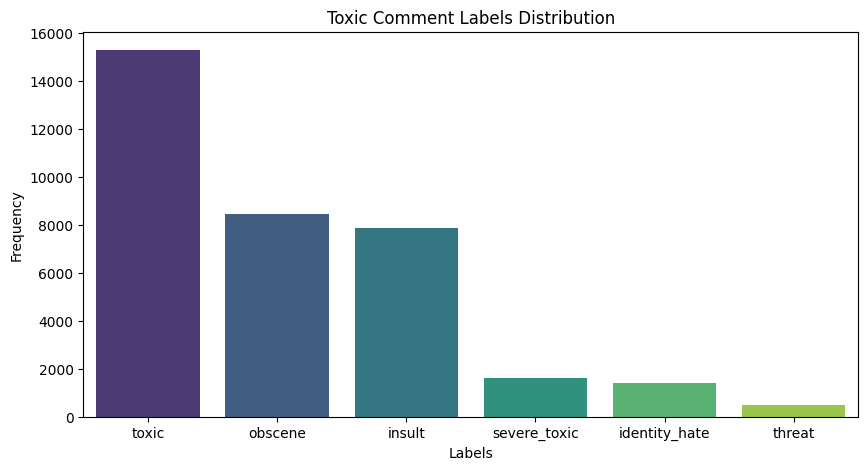

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette='viridis')
plt.title("Toxic Comment Labels Distribution")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.show()

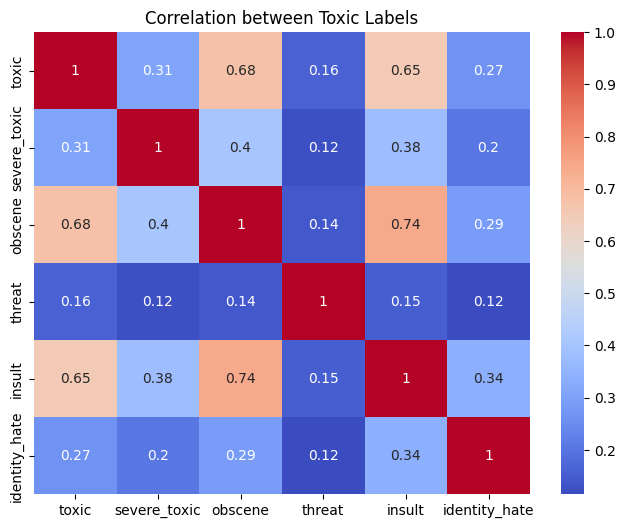

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(data[label_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Toxic Labels")
plt.show()

### ☁️ Word Cloud of Toxic Comments

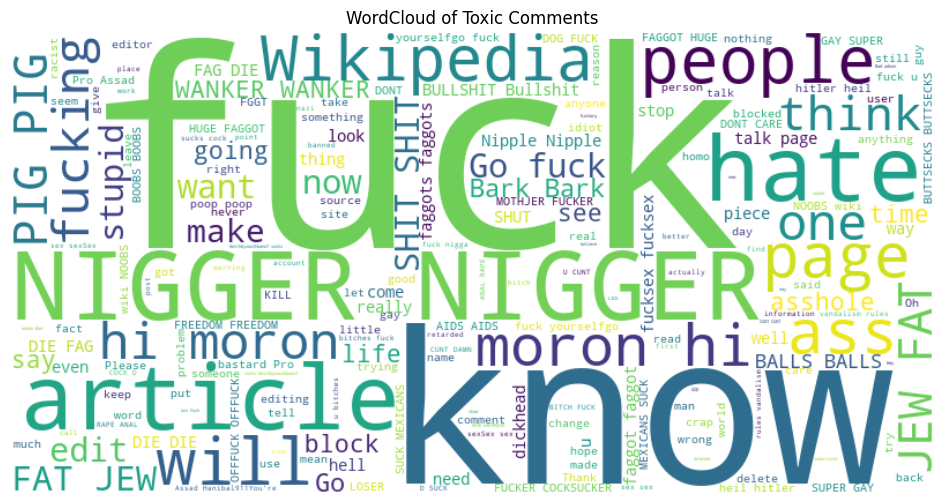

In [12]:

toxic_text = data[data['toxic'] == 1]['comment_text'].astype(str)
toxic_words = " ".join(toxic_text.values)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_words)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Toxic Comments")
plt.show()


### 📌 Label Statistics

In [13]:

row_label_sums = data[label_cols].sum(axis=1)
num_unlabeled = (row_label_sums == 0).sum()

print("Total Comments:", len(data))
print("Comments without any labels:", num_unlabeled)
print("Total Labels Assigned:", row_label_sums.sum())


Total Comments: 159571
Comments without any labels: 143346
Total Labels Assigned: 35098


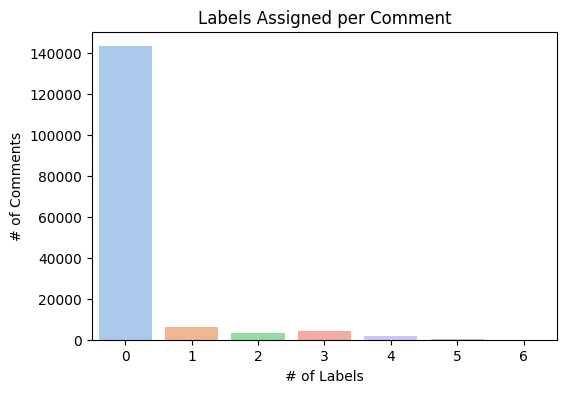

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x=row_label_sums, palette='pastel')
plt.title("Labels Assigned per Comment")
plt.xlabel("# of Labels")
plt.ylabel("# of Comments")
plt.show()

## 🧹 Text Preprocessing

In [15]:

stop_words_set = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def clean_comment(comment):
    comment = comment.lower()
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"'s", "", comment)
    comment = re.sub(r"'ve", " have", comment)
    comment = re.sub(r"can't", "can not", comment)
    comment = re.sub(r"n't", " not", comment)
    comment = re.sub(r"i'm", "i am", comment)
    comment = re.sub(r"'re", " are", comment)
    comment = re.sub(r"'d", " would", comment)
    comment = re.sub(r"'ll", " will", comment)
    comment = re.sub(r"[^a-zA-Z]", " ", comment)
    comment = re.sub(r"\s+", " ", comment)
    return comment.strip()

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words_set])

def apply_stemming(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# Apply preprocessing
cleaned_text = data['comment_text'].apply(clean_comment).apply(remove_stopwords).apply(apply_stemming)
data['cleaned_text'] = cleaned_text
data.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seem stuck thank t...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constant remov...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page


## 🤖 Model Training and Evaluation

In [16]:
X = data['cleaned_text']
y = data[label_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    probabilities = pipeline.predict_proba(X_test)
    print("ROC AUC Score:", roc_auc_score(y_test, probabilities))
    print("Accuracy Score:", accuracy_score(y_test, predictions))
    print("Classification Report:")
    print(classification_report(y_test, predictions, target_names=label_cols))

nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english')),
    ("classifier", OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english')),
    ("classifier", OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])

rf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english')),
    ("classifier", OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42), n_jobs=-1))
])

In [18]:
# Evaluate Models
evaluate_pipeline(nb_pipeline, X_train, X_test, y_train, y_test)

ROC AUC Score: 0.8653642801342906
Accuracy Score: 0.9004543318188939
Classification Report:
               precision    recall  f1-score   support

        toxic       0.99      0.22      0.36      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.98      0.14      0.24      1715
       threat       0.00      0.00      0.00        74
       insult       0.95      0.06      0.12      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.14      0.25      7074
    macro avg       0.49      0.07      0.12      7074
 weighted avg       0.88      0.14      0.24      7074
  samples avg       0.02      0.01      0.01      7074



In [19]:
evaluate_pipeline(lr_pipeline, X_train, X_test, y_train, y_test)

ROC AUC Score: 0.9797450743643616
Accuracy Score: 0.918846937176876
Classification Report:
               precision    recall  f1-score   support

        toxic       0.91      0.62      0.74      3056
 severe_toxic       0.57      0.28      0.38       321
      obscene       0.91      0.64      0.75      1715
       threat       0.73      0.15      0.25        74
       insult       0.81      0.50      0.62      1614
identity_hate       0.71      0.16      0.26       294

    micro avg       0.88      0.56      0.68      7074
    macro avg       0.78      0.39      0.50      7074
 weighted avg       0.86      0.56      0.67      7074
  samples avg       0.06      0.05      0.05      7074



In [20]:
evaluate_pipeline(rf_pipeline, X_train, X_test, y_train, y_test)

ROC AUC Score: 0.9603271319716962
Accuracy Score: 0.9161209462635125
Classification Report:
               precision    recall  f1-score   support

        toxic       0.91      0.59      0.71      3056
 severe_toxic       0.55      0.07      0.13       321
      obscene       0.90      0.64      0.75      1715
       threat       0.45      0.07      0.12        74
       insult       0.80      0.47      0.59      1614
identity_hate       0.75      0.07      0.13       294

    micro avg       0.88      0.52      0.66      7074
    macro avg       0.73      0.32      0.40      7074
 weighted avg       0.85      0.52      0.64      7074
  samples avg       0.05      0.05      0.05      7074



## 🔮 Test Predictions on Sample Comments

In [21]:

def predict_labels(model, text):
    processed = apply_stemming(remove_stopwords(clean_comment(text)))
    prediction = model.predict([processed])[0]
    for label, result in zip(label_cols, prediction):
        print(f"{label:>14}: {result}")

print("\nToxic Sample 1:")
predict_labels(lr_pipeline, "You're such a worthless piece of garbage, nobody cares about you.")



Toxic Sample 1:
         toxic: 1
  severe_toxic: 0
       obscene: 0
        threat: 0
        insult: 0
 identity_hate: 0


In [22]:

print("\nToxic Sample 2:")
predict_labels(lr_pipeline, "hello how are you doing")


Toxic Sample 2:
         toxic: 0
  severe_toxic: 0
       obscene: 0
        threat: 0
        insult: 0
 identity_hate: 0


In [24]:

print("\nToxic Sample 3:")
predict_labels(lr_pipeline, "I hope your entire family dies in a fire. You deserve nothing but pain.")


Toxic Sample 3:
         toxic: 1
  severe_toxic: 0
       obscene: 0
        threat: 1
        insult: 0
 identity_hate: 0


In [25]:

print("\nToxic Sample 4:")
predict_labels(lr_pipeline, "You’re a f***ing b***h and a complete piece of sh*t.")


Toxic Sample 4:
         toxic: 1
  severe_toxic: 0
       obscene: 1
        threat: 0
        insult: 1
 identity_hate: 0
